In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from datetime import datetime, timezone
import datetime
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go

In [2]:
df = pd.read_csv('final_data.csv',parse_dates= ["time"])

In [3]:
df.head()

,grid_square,internet_cdr,time
0,5056,517.607260,2013-01-11 00:00:00
1,5056,314.551305,2013-01-11 00:10:00
2,5056,341.527327,2013-01-11 00:20:00
3,5056,450.012415,2013-01-11 00:30:00
4,5056,312.166782,2013-01-11 00:40:00


In [4]:
df.shape

(80352, 3)

<AxesSubplot:xlabel='internet_cdr'>

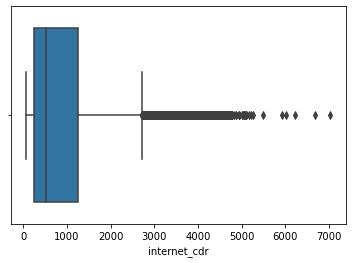

In [5]:
sns.boxplot(x=df['internet_cdr'])

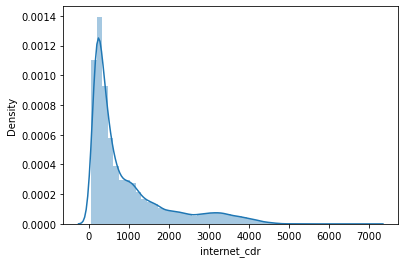

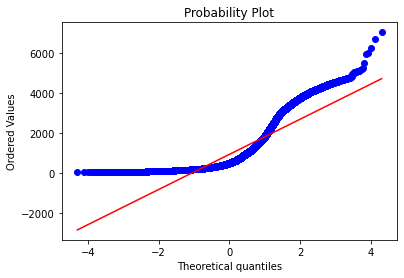

In [6]:
fig = plt.figure()
ax = fig.gca()
sns.distplot(df['internet_cdr'])
plt.show()

#Probability plot
fig = plt.figure()
res = stats.probplot(df['internet_cdr'], plot=plt)

In [7]:
df.describe()

,grid_square,internet_cdr
count,80352.000000,80352.000000
mean,5157.000000,946.860543
std,81.654249,997.389860
min,5056.000000,57.823422
25%,5058.000000,253.398926
50%,5157.000000,508.896077
75%,5256.000000,1243.336593
max,5258.000000,7033.454732


## Tukey’s box plot method

-  Tukey distinguishes between possible and probable outliers. 
- 1- A possible outlier is located between the inner and the outer fence, 
- 2- whereas a probable outlier is located outside the outer fence.

![Image](Outputs/Tukeys-Box-plot-method/Tukey’s-box.jpg)

#### First apply on a random grid

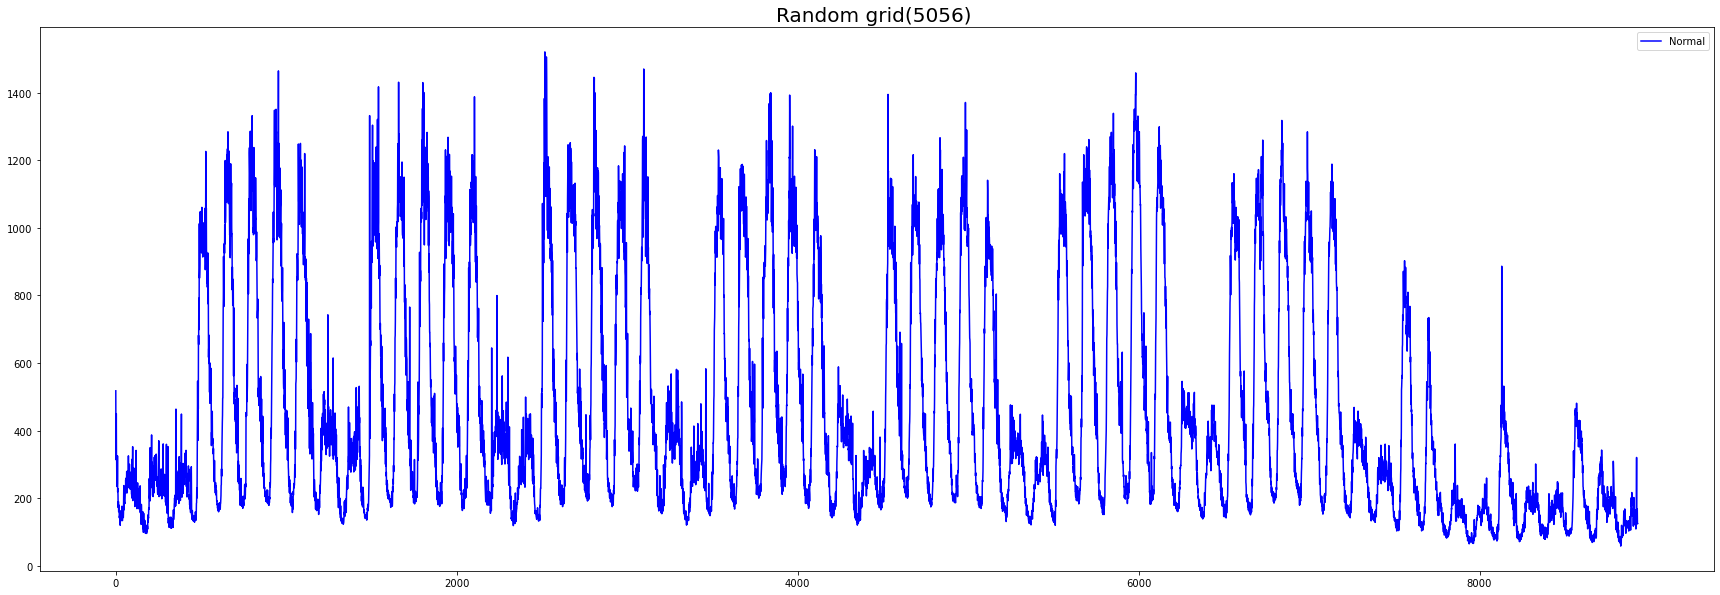

In [8]:
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(df.groupby("grid_square").get_group(5056).index, 
        df.groupby("grid_square").get_group(5056)['internet_cdr'], color='blue', label = 'Normal')
ax.set_title('Random grid(5056) ', fontsize=20)
plt.legend()
plt.show();

In [9]:
def tukeys_method(df, variable):
    #Takes two parameters: dataframe & variable of interest as string
    q1 = df[variable].quantile(0.25)
    q3 = df[variable].quantile(0.75)
    iqr = q3-q1
    inner_fence = 1.5*iqr
    outer_fence = 3*iqr
    
    #inner fence lower and upper end
    inner_fence_le = q1-inner_fence
    inner_fence_ue = q3+inner_fence
    
    #outer fence lower and upper end
    outer_fence_le = q1-outer_fence
    outer_fence_ue = q3+outer_fence
    
    outliers_prob = []
    outliers_poss = []
    for index, x in enumerate(df[variable]):
        if x <= outer_fence_le or x >= outer_fence_ue:
            outliers_prob.append(index)
    for index, x in enumerate(df[variable]):
        if x <= inner_fence_le or x >= inner_fence_ue:
            outliers_poss.append(index)
    return outliers_prob, outliers_poss


In [10]:
random_grid=df.groupby("grid_square").get_group(5056)

probable_outliers_tm, possible_outliers_tm = tukeys_method(random_grid, "internet_cdr")

print(probable_outliers_tm)
print("*****************************************************************************************")
print(possible_outliers_tm)

[]
*****************************************************************************************
[800, 931, 939, 940, 954, 1489, 1541, 1659, 1799, 1801, 1802, 1806, 1807, 2104, 2514, 2517, 2524, 2526, 2527, 2804, 2805, 2806, 2807, 2811, 3097, 3098, 3831, 3832, 3833, 3835, 3839, 3842, 3953, 4530, 4984, 5852, 5975, 5979, 5981, 5982, 5983, 5995, 5996]


In [11]:
len(probable_outliers_tm)

0

In [12]:
len(possible_outliers_tm)

43

In [13]:
anomaly = pd.DataFrame(possible_outliers_tm)
anomaly['Anomaly'] = 1
anomaly.set_index(0, inplace=True)

In [14]:
random_grid = pd.concat([random_grid, anomaly], axis=1)

In [15]:
random_grid['Anomaly'] = random_grid['Anomaly'].replace(np.nan, False)
random_grid['Anomaly'] = random_grid['Anomaly'].replace(1.0, True)

In [16]:
random_grid

,grid_square,internet_cdr,time,Anomaly
0,5056,517.607260,2013-01-11 00:00:00,False
1,5056,314.551305,2013-01-11 00:10:00,False
2,5056,341.527327,2013-01-11 00:20:00,False
3,5056,450.012415,2013-01-11 00:30:00,False
4,5056,312.166782,2013-01-11 00:40:00,False
...,...,...,...,...
8923,5056,135.564582,2014-01-01 23:10:00,False
8924,5056,143.685136,2014-01-01 23:20:00,False
8925,5056,168.564783,2014-01-01 23:30:00,False
8926,5056,123.497984,2014-01-01 23:40:00,False


In [17]:
random_grid['Anomaly'].value_counts()

False    8885
True       43
Name: Anomaly, dtype: int64

In [18]:
# fig1 = px.line(random_grid,  y="internet_cdr")
# fig1.update_traces(line=dict(color = 'magenta'))

# anomaly = random_grid.loc[random_grid['Anomaly'] == True, ['internet_cdr']] 
# fig2 = px.scatter(anomaly,y="internet_cdr")

# fig3 = go.Figure(data=fig1.data + fig2.data)
# fig3.update_layout(title="Random grid(5056) anomalies points for box blot method")
# fig3.show()

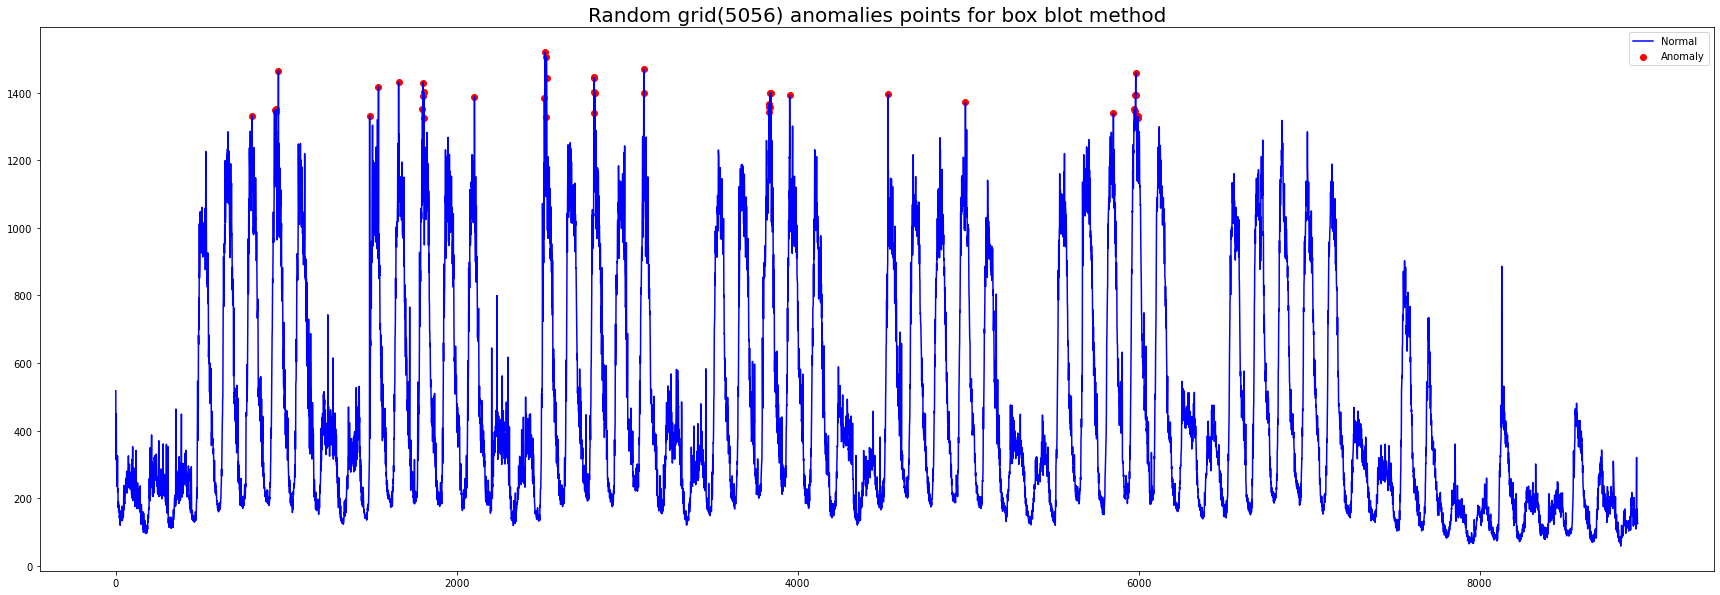

In [19]:
fig, ax = plt.subplots(figsize=(30,10))

anomaly = random_grid.loc[random_grid['Anomaly'] == True, ['internet_cdr']] 

ax.plot(random_grid.index, random_grid['internet_cdr'], color='blue', label = 'Normal')
ax.scatter(anomaly.index,anomaly['internet_cdr'], color='red', label = 'Anomaly')
ax.set_title('Random grid(5056) anomalies points for box blot method', fontsize=20)
plt.legend()
plt.show();

#### Second apply on all grids 

In [20]:
df = pd.read_csv('final_data.csv',parse_dates= ["time"])

In [21]:
full_grid = df.groupby("grid_square")
grids = list(full_grid.groups.keys())

In [22]:
grids

[5056, 5057, 5058, 5156, 5157, 5158, 5256, 5257, 5258]

In [23]:
data=[]
for grid in grids:
    full_grid = df.groupby("grid_square").get_group(grid)
    data.append(full_grid)
data

[      grid_square  internet_cdr                time
 0            5056    517.607260 2013-01-11 00:00:00
 1            5056    314.551305 2013-01-11 00:10:00
 2            5056    341.527327 2013-01-11 00:20:00
 3            5056    450.012415 2013-01-11 00:30:00
 4            5056    312.166782 2013-01-11 00:40:00
 ...           ...           ...                 ...
 8923         5056    135.564582 2014-01-01 23:10:00
 8924         5056    143.685136 2014-01-01 23:20:00
 8925         5056    168.564783 2014-01-01 23:30:00
 8926         5056    123.497984 2014-01-01 23:40:00
 8927         5056    124.569821 2014-01-01 23:50:00
 
 [8928 rows x 3 columns],
        grid_square  internet_cdr                time
 8928          5057    403.180777 2013-01-11 00:00:00
 8929          5057    310.131943 2013-01-11 00:10:00
 8930          5057    308.682959 2013-01-11 00:20:00
 8931          5057    357.021359 2013-01-11 00:30:00
 8932          5057    303.474336 2013-01-11 00:40:00
 ...        

In [24]:
x=len(grids)
x

9

In [25]:
data_2=pd.DataFrame()
anomalies= pd.DataFrame()
for i in range(x):
    

    probable_outliers_tm, possible_outliers_tm = tukeys_method(data[i], "internet_cdr")
    
    anomaly = pd.DataFrame(possible_outliers_tm)
    anomaly['Anomaly'] = 1
    anomaly.set_index(0, inplace=True)

    data_2 = pd.concat([data[i].reset_index(drop=True), anomaly], axis=1)
    
    print("========== grid number {} done ==========".format(i+1))
    print(data_2['Anomaly'].value_counts())
    
    
    anomalies=anomalies.append(data_2)
    print(data_2)
    print("===================================================================")
#     print(anomalies)

========== grid number 1 done ==========
1.0    43
Name: Anomaly, dtype: int64
      grid_square  internet_cdr                time  Anomaly
0            5056    517.607260 2013-01-11 00:00:00      NaN
1            5056    314.551305 2013-01-11 00:10:00      NaN
2            5056    341.527327 2013-01-11 00:20:00      NaN
3            5056    450.012415 2013-01-11 00:30:00      NaN
4            5056    312.166782 2013-01-11 00:40:00      NaN
...           ...           ...                 ...      ...
8923         5056    135.564582 2014-01-01 23:10:00      NaN
8924         5056    143.685136 2014-01-01 23:20:00      NaN
8925         5056    168.564783 2014-01-01 23:30:00      NaN
8926         5056    123.497984 2014-01-01 23:40:00      NaN
8927         5056    124.569821 2014-01-01 23:50:00      NaN

[8928 rows x 4 columns]
========== grid number 2 done ==========
1.0    33
Name: Anomaly, dtype: int64
      grid_square  internet_cdr                time  Anomaly
0            5057    403

In [26]:
#     probable_outliers_tm, possible_outliers_tm = tukeys_method(data[2], "internet_cdr")
    
#     anomaly = pd.DataFrame(possible_outliers_tm)
#     anomaly['Anomaly'] = 1
#     anomaly.set_index(0, inplace=True)

#     x=pd.concat([data[2].reset_index(drop=True), anomaly], axis=1)
#     print (x)
#     print(x['Anomaly'].value_counts())

#     print("========== grid number {} done ==========".format(i+1))

In [27]:
anomalies.reset_index(drop=True,inplace=True)

In [28]:
anomalies['Anomaly'] = anomalies['Anomaly'].replace(np.nan, False)
anomalies['Anomaly'] = anomalies['Anomaly'].replace(1.0, True)

In [29]:
anomalies['Anomaly'].value_counts()

False    80137
True       215
Name: Anomaly, dtype: int64

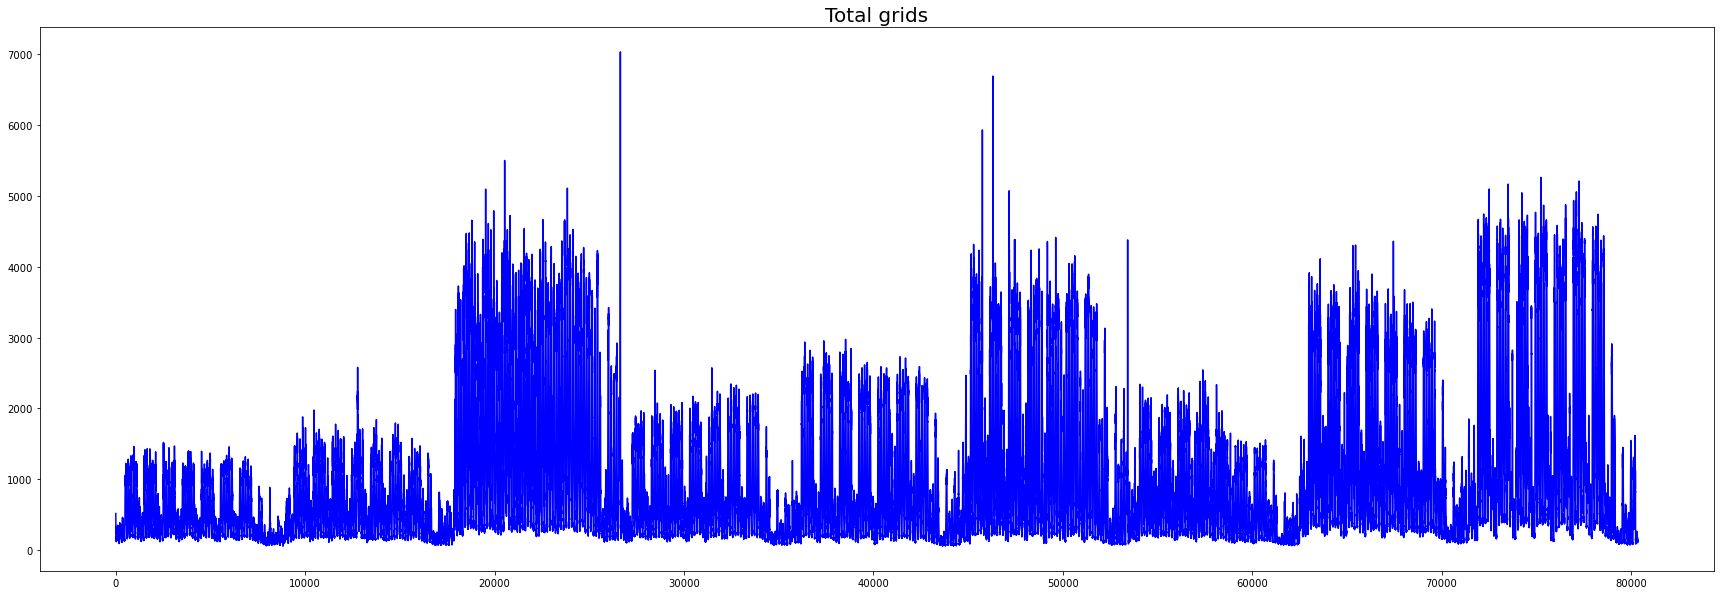

In [30]:
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(df.index, df['internet_cdr'], color='blue', label = 'Normal')
ax.set_title('Total grids', fontsize=20)
plt.show();

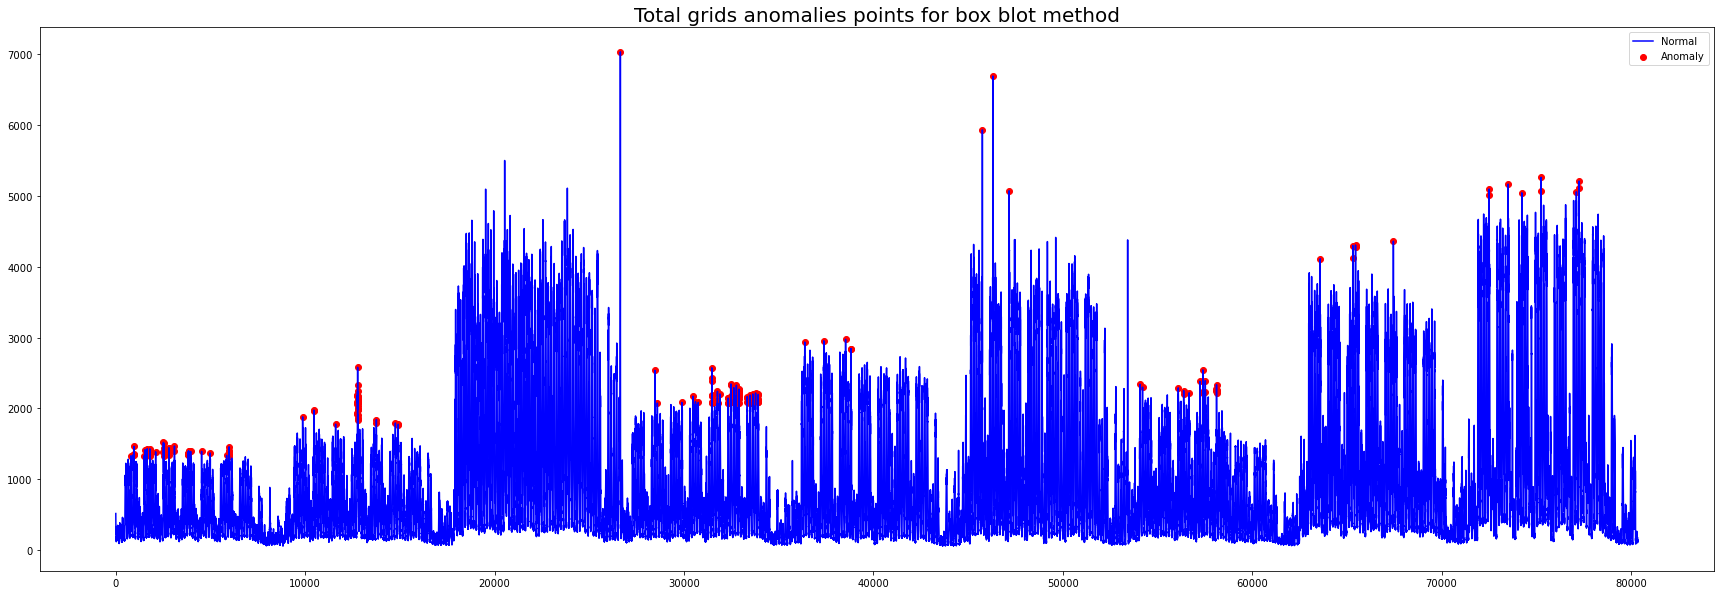

In [31]:
fig, ax = plt.subplots(figsize=(30,10))

anomaly = anomalies.loc[anomalies['Anomaly'] == True, ['internet_cdr']] 

ax.plot(df.index, df['internet_cdr'], color='blue', label = 'Normal')
ax.scatter(anomaly.index,anomaly['internet_cdr'], color='red', label = 'Anomaly')
ax.set_title('Total grids anomalies points for box blot method', fontsize=20)
plt.legend()
plt.show();